In [1]:
from __future__ import print_function

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
#os.environ["CUDA_VISIBLE_DEVICES"]='0,1,2,3'
import sys
import argparse
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms
import videotransforms_attention

import numpy as np

from pytorch_i3d_attention_gaze import InceptionI3d

from z_my_egtea_dataset_attention_gaze import Egtea as Dataset

from pytorch_ranger import Ranger, RangerVA

Random Seed:  922


In [2]:
n_wkers = 8
b_sz = 50#24
mx_steps = 64e3

# try to set random seed
manualSeed = 922
print("Random Seed: ", manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  922


In [3]:
def calculate_loss(i3d, dataloader):
    tot_loss = 0.0
    tot_gaze_loss = 0.0
    tot_loss = np.array([])
    tot_gaze_loss = np.array([])
    i3d.eval()
    
    with torch.no_grad():

        for data in dataloader:
            inputs, labels, gt_labels, gaze_locs = data

            # wrap them in Variable
            inputs = Variable(inputs.cuda())
            t = inputs.size(2)
            labels = Variable(labels.cuda())

            gt_labels = Variable(gt_labels.cuda())

            per_frame_logits, a_map = i3d(inputs)

            #print inputs.shape, per_frame_logits.shape, gaze_locs.shape #(12, 3, 16, 224, 224) (12, 106, 1) (12, 16, 2)

            # upsample to input size
            per_frame_logits = F.upsample(per_frame_logits, t, mode='linear')

            loss = F.cross_entropy(torch.max(per_frame_logits, dim=2)[0], gt_labels)
            #loss /= num_steps_per_update

            #tot_loss += loss.data.item() #/ len(inputs)
            tot_loss = np.append(tot_loss, loss.data.item())


            a_map = a_map.squeeze(1)

            map_N, map_t, map_height, map_width = a_map.shape
            map_Data_s = torch.zeros([map_N, map_t, map_height, map_width], dtype=torch.float32)

            for n_idx in range(map_N):
                gaze_avg1 = torch.mean(gaze_locs[n_idx, 0:8, :], dim=0)
                gaze_avg2 = torch.mean(gaze_locs[n_idx, 8:16, :], dim=0)

                x, y = gaze_avg1[0] * map_width, gaze_avg1[1] * map_height
                u, v = gaze_avg2[0] * map_width, gaze_avg2[1] * map_height
                sigma = 3
                for i in range(0, map_height):
                    for j in range(0, map_width):
                        map_Data_s[n_idx, 0, i, j] = torch.exp(-1.0 * ((j - x) * (j - x) + (i - y) * (i - y)) / (2 * sigma * sigma))
                        map_Data_s[n_idx, 1, i, j] = torch.exp(-1.0 * ((j - u) * (j - u) + (i - v) * (i - v)) / (2 * sigma * sigma))

            map_Data_s = map_Data_s.cuda()

            gaze_loss = F.mse_loss(map_Data_s, a_map)
            #gaze_loss /= num_steps_per_update

    #         tot_gaze_loss += gaze_loss.item() #/ len(inputs)
            tot_gaze_loss = np.append(tot_gaze_loss, gaze_loss.data.item())

        #return tot_loss/len(dataloader.dataset), tot_gaze_loss/len(dataloader.dataset)
    #    return tot_loss, tot_gaze_loss
        return tot_loss.mean(), tot_gaze_loss.mean()

In [4]:
#len dataset: 7800

In [5]:
def run(init_lr=0.1, max_steps=64e3, mode='rgb', batch_size=b_sz, save_model='./tmp/'):

    if mode == 'flow':
        root = './dataset/EGTEA_Gaze_plus/z_frames_flow'
    else:
        root = './dataset/EGTEA_Gaze_plus/z_frames_rgb'

    gaze_root = './dataset/EGTEA_Gaze_plus/z_gaze_data'
    train_split = './dataset/EGTEA_Gaze_plus/action_annotation/train_split4.txt'
    val_split = './dataset/EGTEA_Gaze_plus/action_annotation/val_split.txt'

    # setup dataset
    train_transforms = transforms.Compose([videotransforms_attention.RandomCrop(224),
                                           videotransforms_attention.RandomHorizontalFlip(),
    ])

    dataset = Dataset(train_split, 'training', root, gaze_root, mode, train_transforms)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=n_wkers, pin_memory=True)

    dataset_val = Dataset(val_split, 'val', root, gaze_root, mode, train_transforms)
    dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=20, shuffle=True, num_workers=n_wkers, pin_memory=True)

    dataloaders = {'train': dataloader, 'val': dataloader_val}
#     dataloaders = {'train': dataloader}
    
    # setup the model
    if mode == 'flow':
        i3d = InceptionI3d(106, in_channels=2)
        i3d.load_state_dict(torch.load('models/flow_o.pt'), strict=False)
    else:
        i3d = InceptionI3d(106, in_channels=3, expanded=False)
        i3d.load_state_dict(torch.load('models/rgb_o.pt'), strict=False)
    
    i3d.cuda()
    i3d = nn.DataParallel(i3d, device_ids=[0, 1])

    lr = init_lr
#     optimizer = optim.SGD(i3d.parameters(), lr=lr, momentum=0.9, weight_decay=0.0000001)
#     lr_sched = optim.lr_scheduler.MultiStepLR(optimizer, [300, 1000])
    optimizer = Ranger(i3d.parameters())
    lr_sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)
    
    scaler = torch.cuda.amp.GradScaler()

    num_steps_per_update = 4 # accum gradient
    steps = 0
    best_loss_val = 2.0
    best_steps = 0
    
    # train it
    while steps < max_steps:#for epoch in range(num_epochs):
        print(optimizer.param_groups[0]['lr'])
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                i3d.train(True)
            else:
                i3d.train(False)  # Set model to evaluate mode
                
            tot_loss = 0.0
            tot_gaze_loss = 0.0

            num_iter = 0
            optimizer.zero_grad()
            
            # Iterate over data.
            for data in dataloaders[phase]:
                num_iter += 1
                # get the inputs
                inputs, labels, gt_labels, gaze_locs = data
                

                # wrap them in Variable
                inputs = Variable(inputs.cuda())
                t = inputs.size(2)
                labels = Variable(labels.cuda())
                gt_labels = Variable(gt_labels.cuda())
                                    
                with torch.cuda.amp.autocast():
                    per_frame_logits, a_map = i3d(inputs)

                    # upsample to input size
                    per_frame_logits = F.upsample(per_frame_logits, t, mode='linear')

                    loss = F.cross_entropy(torch.max(per_frame_logits, dim=2)[0], gt_labels)                    
                    loss /= num_steps_per_update

                    tot_loss += loss.data.item()
                    
                    a_map = a_map.squeeze(1)

                    map_N, map_t, map_height, map_width = a_map.shape
                    map_Data_s = torch.zeros([map_N, map_t, map_height, map_width], dtype=torch.float32)

                    for n_idx in range(map_N):
                        gaze_avg1 = torch.mean(gaze_locs[n_idx, 0:8, :], dim=0)
                        gaze_avg2 = torch.mean(gaze_locs[n_idx, 8:16, :], dim=0)

                        x, y = gaze_avg1[0] * map_width, gaze_avg1[1] * map_height
                        u, v = gaze_avg2[0] * map_width, gaze_avg2[1] * map_height
                        sigma = 3
                        for i in range(0, map_height):
                            for j in range(0, map_width):
                                map_Data_s[n_idx, 0, i, j] = torch.exp(-1.0 * ((j - x) * (j - x) + (i - y) * (i - y)) / (2 * sigma * sigma))
                                map_Data_s[n_idx, 1, i, j] = torch.exp(-1.0 * ((j - u) * (j - u) + (i - v) * (i - v)) / (2 * sigma * sigma))

                    map_Data_s = map_Data_s.cuda()

                    gaze_loss = F.mse_loss(map_Data_s, a_map)
                    gaze_loss /= num_steps_per_update

                    tot_gaze_loss += gaze_loss.item()

                    loss_two = loss + gaze_loss*0.1
                
                scaler.scale(loss_two).backward()
                #loss_two.backward()

                if num_iter == num_steps_per_update and phase == 'train':
                    steps += 1
                    num_iter = 0
                    #optimizer.step()
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    #lr_sched.step()
                    lr_sched.step(loss_two)
                    
                    num_steps_to_eval = 10
                    
                    if steps % num_steps_to_eval == 0:                           
                        with torch.cuda.amp.autocast():
                            loss_val, gaze_loss_val = calculate_loss(i3d, dataloader_val)
                            
                            print('Step {}/{}'.format(steps, max_steps))
                            print('Train Tot Loss: {:.4f} Train Gaze Loss: {:.4f} - Val Tot Loss: {:.4f} Val Gaze Loss: {:.4f}'.format(tot_loss/num_steps_to_eval, tot_gaze_loss/num_steps_to_eval, loss_val, gaze_loss_val))
                        
#                         print('Step {}/{}'.format(steps, max_steps))
#                         print('Train Tot Loss: {:.4f} Train Gaze Loss: {:.4f}'.format(tot_loss/num_steps_to_eval, tot_gaze_loss/num_steps_to_eval))
                            
                            with open('output.txt', 'a') as f:
                                f.write('Step {}/{}\n'.format(steps, max_steps))
                                f.write('Train Tot Loss: {:.4f} Train Gaze Loss: {:.4f} - Val Tot Loss: {:.4f} Val Gaze Loss: {:.4f}\n'.format(tot_loss/num_steps_to_eval, tot_gaze_loss/num_steps_to_eval, loss_val, gaze_loss_val))                            
                        
                            if loss_val < best_loss_val:
                                if os.path.exists(save_model+str(best_steps).zfill(6)+'_best.pt'):
                                    os.remove(save_model+str(best_steps).zfill(6)+'_best.pt')
                                
                                best_loss_val = loss_val
                                best_steps = steps
                                
                                torch.save(i3d.module.state_dict(), save_model+str(steps).zfill(6)+'_best.pt')
                        
                        if steps % 150 == 0:
                            # save model
                            torch.save(i3d.module.state_dict(), save_model+str(steps).zfill(6)+'.pt')
                        tot_loss = tot_gaze_loss = 0.

In [6]:
run(max_steps=600)

0.001
----------


/data/axel/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/data/axel/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/data/axel/miniconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internall

Step 10/600
Train Tot Loss: 2.0471 Train Gaze Loss: 0.4363 - Val Tot Loss: 4.6678 Val Gaze Loss: 0.3825
Step 20/600
Train Tot Loss: 2.5486 Train Gaze Loss: 0.2669 - Val Tot Loss: 0.9084 Val Gaze Loss: 0.2074
Step 30/600
Train Tot Loss: 0.6206 Train Gaze Loss: 0.7332 - Val Tot Loss: 0.9691 Val Gaze Loss: 0.9777
0.00025
----------
Step 40/600
Train Tot Loss: 0.1812 Train Gaze Loss: 0.0308 - Val Tot Loss: 0.8578 Val Gaze Loss: 0.7725
Step 50/600
Train Tot Loss: 0.5897 Train Gaze Loss: 0.6820 - Val Tot Loss: 0.8136 Val Gaze Loss: 0.7033
Step 60/600
Train Tot Loss: 0.5794 Train Gaze Loss: 0.5568 - Val Tot Loss: 0.8890 Val Gaze Loss: 0.6944
Step 70/600
Train Tot Loss: 0.5846 Train Gaze Loss: 0.5279 - Val Tot Loss: 0.9471 Val Gaze Loss: 0.6166
3.90625e-06
----------
Step 80/600
Train Tot Loss: 0.3544 Train Gaze Loss: 0.0692 - Val Tot Loss: 0.8052 Val Gaze Loss: 0.5142
Step 90/600
Train Tot Loss: 0.5426 Train Gaze Loss: 0.4325 - Val Tot Loss: 0.9029 Val Gaze Loss: 0.5488
Step 100/600
Train Tot

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

import os
import sys
from collections import OrderedDict


class MaxPool3dSamePadding(nn.MaxPool3d):
    
    def compute_pad(self, dim, s):
        if s % self.stride[dim] == 0:
            return max(self.kernel_size[dim] - self.stride[dim], 0)
        else:
            return max(self.kernel_size[dim] - (s % self.stride[dim]), 0)

    def forward(self, x):
        # compute 'same' padding
        (batch, channel, t, h, w) = x.size()
        #print t,h,w
        out_t = np.ceil(float(t) / float(self.stride[0]))
        out_h = np.ceil(float(h) / float(self.stride[1]))
        out_w = np.ceil(float(w) / float(self.stride[2]))
        #print out_t, out_h, out_w
        pad_t = self.compute_pad(0, t)
        pad_h = self.compute_pad(1, h)
        pad_w = self.compute_pad(2, w)
        #print pad_t, pad_h, pad_w

        pad_t_f = pad_t // 2
        pad_t_b = pad_t - pad_t_f
        pad_h_f = pad_h // 2
        pad_h_b = pad_h - pad_h_f
        pad_w_f = pad_w // 2
        pad_w_b = pad_w - pad_w_f

        pad = (pad_w_f, pad_w_b, pad_h_f, pad_h_b, pad_t_f, pad_t_b)
        #print x.size()
        #print pad
        x = F.pad(x, pad)
        return super(MaxPool3dSamePadding, self).forward(x)
    

class Unit3D(nn.Module):

    def __init__(self, in_channels,
                 output_channels,
                 kernel_shape=(1, 1, 1),
                 stride=(1, 1, 1),
                 padding=0,
                 activation_fn=F.relu,
                 use_batch_norm=True,
                 use_bias=False,
                 name='unit_3d'):
        
        """Initializes Unit3D module."""
        super(Unit3D, self).__init__()
        
        self._output_channels = output_channels
        self._kernel_shape = kernel_shape
        self._stride = stride
        self._use_batch_norm = use_batch_norm
        self._activation_fn = activation_fn
        self._use_bias = use_bias
        self.name = name
        self.padding = padding
        
        self.conv3d = nn.Conv3d(in_channels=in_channels,
                                out_channels=self._output_channels,
                                kernel_size=self._kernel_shape,
                                stride=self._stride,
                                padding=0, # we always want padding to be 0 here. We will dynamically pad based on input size in forward function
                                bias=self._use_bias)
        
        if self._use_batch_norm:
            self.bn = nn.BatchNorm3d(self._output_channels, eps=0.001, momentum=0.01)

    def compute_pad(self, dim, s):
        if s % self._stride[dim] == 0:
            return max(self._kernel_shape[dim] - self._stride[dim], 0)
        else:
            return max(self._kernel_shape[dim] - (s % self._stride[dim]), 0)

            
    def forward(self, x):
        # compute 'same' padding
        (batch, channel, t, h, w) = x.size()
        #print t,h,w
        out_t = np.ceil(float(t) / float(self._stride[0]))
        out_h = np.ceil(float(h) / float(self._stride[1]))
        out_w = np.ceil(float(w) / float(self._stride[2]))
        #print out_t, out_h, out_w
        pad_t = self.compute_pad(0, t)
        pad_h = self.compute_pad(1, h)
        pad_w = self.compute_pad(2, w)
        #print pad_t, pad_h, pad_w

        pad_t_f = pad_t // 2
        pad_t_b = pad_t - pad_t_f
        pad_h_f = pad_h // 2
        pad_h_b = pad_h - pad_h_f
        pad_w_f = pad_w // 2
        pad_w_b = pad_w - pad_w_f

        pad = (pad_w_f, pad_w_b, pad_h_f, pad_h_b, pad_t_f, pad_t_b)
        #print x.size()
        #print pad
        x = F.pad(x, pad)
        #print x.size()        

        x = self.conv3d(x)
        if self._use_batch_norm:
            x = self.bn(x)
        if self._activation_fn is not None:
            x = self._activation_fn(x)
        return x



class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels, name):
        super(InceptionModule, self).__init__()

        self.b0 = Unit3D(in_channels=in_channels, output_channels=out_channels[0], kernel_shape=[1, 1, 1], padding=0,
                         name=name+'/Branch_0/Conv3d_0a_1x1')
        self.b1a = Unit3D(in_channels=in_channels, output_channels=out_channels[1], kernel_shape=[1, 1, 1], padding=0,
                          name=name+'/Branch_1/Conv3d_0a_1x1')
        self.b1b = Unit3D(in_channels=out_channels[1], output_channels=out_channels[2], kernel_shape=[3, 3, 3],
                          name=name+'/Branch_1/Conv3d_0b_3x3')
        self.b2a = Unit3D(in_channels=in_channels, output_channels=out_channels[3], kernel_shape=[1, 1, 1], padding=0,
                          name=name+'/Branch_2/Conv3d_0a_1x1')
        self.b2b = Unit3D(in_channels=out_channels[3], output_channels=out_channels[4], kernel_shape=[3, 3, 3],
                          name=name+'/Branch_2/Conv3d_0b_3x3')
        self.b3a = MaxPool3dSamePadding(kernel_size=[3, 3, 3],
                                stride=(1, 1, 1), padding=0)
        self.b3b = Unit3D(in_channels=in_channels, output_channels=out_channels[5], kernel_shape=[1, 1, 1], padding=0,
                          name=name+'/Branch_3/Conv3d_0b_1x1')
        self.name = name

    def forward(self, x):    
        b0 = self.b0(x)
        b1 = self.b1b(self.b1a(x))
        b2 = self.b2b(self.b2a(x))
        b3 = self.b3b(self.b3a(x))
        return torch.cat([b0,b1,b2,b3], dim=1)


class InceptionI3d(nn.Module):
    """Inception-v1 I3D architecture.
    The model is introduced in:
        Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset
        Joao Carreira, Andrew Zisserman
        https://arxiv.org/pdf/1705.07750v1.pdf.
    See also the Inception architecture, introduced in:
        Going deeper with convolutions
        Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed,
        Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich.
        http://arxiv.org/pdf/1409.4842v1.pdf.
    """

    # Endpoints of the model in order. During construction, all the endpoints up
    # to a designated `final_endpoint` are returned in a dictionary as the
    # second return value.
    VALID_ENDPOINTS = (
        'Conv3d_1a_7x7',
        'MaxPool3d_2a_3x3',
        'Conv3d_2b_1x1',
        'Conv3d_2c_3x3',
        'MaxPool3d_3a_3x3',
        'Mixed_3b',
        'Mixed_3c',
        'MaxPool3d_4a_3x3',
        'Mixed_4b',
        'Mixed_4c',
        'Mixed_4d',
        'Mixed_4e',
        'Mixed_4f',
        'MaxPool3d_5a_2x2',
        'Mixed_5b',
        'Mixed_5c',
        'Logits',
        'Predictions',
    )

    def __init__(self, num_classes=400, spatial_squeeze=True,
                 final_endpoint='Logits', name='inception_i3d', in_channels=3, dropout_keep_prob=0.5):
        """Initializes I3D model instance.
        Args:
          num_classes: The number of outputs in the logit layer (default 400, which
              matches the Kinetics dataset).
          spatial_squeeze: Whether to squeeze the spatial dimensions for the logits
              before returning (default True).
          final_endpoint: The model contains many possible endpoints.
              `final_endpoint` specifies the last endpoint for the model to be built
              up to. In addition to the output at `final_endpoint`, all the outputs
              at endpoints up to `final_endpoint` will also be returned, in a
              dictionary. `final_endpoint` must be one of
              InceptionI3d.VALID_ENDPOINTS (default 'Logits').
          name: A string (optional). The name of this module.
        Raises:
          ValueError: if `final_endpoint` is not recognized.
        """

        if final_endpoint not in self.VALID_ENDPOINTS:
            raise ValueError('Unknown final endpoint %s' % final_endpoint)

        super(InceptionI3d, self).__init__()
        self._num_classes = num_classes
        self._spatial_squeeze = spatial_squeeze
        self._final_endpoint = final_endpoint
        self.logits = None

        if self._final_endpoint not in self.VALID_ENDPOINTS:
            raise ValueError('Unknown final endpoint %s' % self._final_endpoint)

        self.end_points = {}
        end_point = 'Conv3d_1a_7x7'
        self.end_points[end_point] = Unit3D(in_channels=in_channels, output_channels=64, kernel_shape=[7, 7, 7],
                                            stride=(2, 2, 2), padding=(3,3,3),  name=name+end_point)
        if self._final_endpoint == end_point: return
        
        end_point = 'MaxPool3d_2a_3x3'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[1, 3, 3], stride=(1, 2, 2),
                                                             padding=0)
        if self._final_endpoint == end_point: return
        
        end_point = 'Conv3d_2b_1x1'
        self.end_points[end_point] = Unit3D(in_channels=64, output_channels=64, kernel_shape=[1, 1, 1], padding=0,
                                       name=name+end_point)
        if self._final_endpoint == end_point: return
        
        end_point = 'Conv3d_2c_3x3'
        self.end_points[end_point] = Unit3D(in_channels=64, output_channels=192, kernel_shape=[3, 3, 3], padding=1,
                                       name=name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'MaxPool3d_3a_3x3'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[1, 3, 3], stride=(1, 2, 2),
                                                             padding=0)
        if self._final_endpoint == end_point: return
        
        end_point = 'Mixed_3b'
        self.end_points[end_point] = InceptionModule(192, [64,96,128,16,32,32], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_3c'
        self.end_points[end_point] = InceptionModule(256, [128,128,192,32,96,64], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'MaxPool3d_4a_3x3'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[3, 3, 3], stride=(2, 2, 2),
                                                             padding=0)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4b'
        self.end_points[end_point] = InceptionModule(128+192+96+64, [192,96,208,16,48,64], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4c'
        self.end_points[end_point] = InceptionModule(192+208+48+64, [160,112,224,24,64,64], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4d'
        self.end_points[end_point] = InceptionModule(160+224+64+64, [128,128,256,24,64,64], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4e'
        self.end_points[end_point] = InceptionModule(128+256+64+64, [112,144,288,32,64,64], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4f'
        self.end_points[end_point] = InceptionModule(112+288+64+64, [256,160,320,32,128,128], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'MaxPool3d_5a_2x2'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[2, 2, 2], stride=(2, 2, 2),
                                                             padding=0)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_5b'
        self.end_points[end_point] = InceptionModule(256+320+128+128, [256,160,320,32,128,128], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_5c'
        self.end_points[end_point] = InceptionModule(256+320+128+128, [384,192,384,48,128,128], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Attention_Inc'
        self.attention_inc = InceptionModule(384+384+128+128, [384,192,384,48,128,128], name+end_point)
        self.attention_pred = Unit3D(in_channels=384+384+128+128, output_channels=1,
                             kernel_shape=[1, 1, 1],
                             padding=0,
                             name='attention_pred')

        end_point = 'Logits'
        self.avg_pool = nn.AvgPool3d(kernel_size=[2, 7, 7],
                                     stride=(1, 1, 1))
        self.dropout = nn.Dropout(dropout_keep_prob)
        self.logits = Unit3D(in_channels=384+384+128+128, output_channels=self._num_classes,
                             kernel_shape=[1, 1, 1],
                             padding=0,
                             activation_fn=None,
                             use_batch_norm=False,
                             use_bias=True,
                             name='logits')

        self.build()


    def replace_logits(self, num_classes):
        self._num_classes = num_classes
        self.logits = Unit3D(in_channels=384+384+128+128, output_channels=self._num_classes,
                             kernel_shape=[1, 1, 1],
                             padding=0,
                             activation_fn=None,
                             use_batch_norm=False,
                             use_bias=True,
                             name='logits')
        
    
    def build(self):
        for k in self.end_points.keys():
            self.add_module(k, self.end_points[k])
        
    def forward(self, x):
        for end_point in self.VALID_ENDPOINTS:
            if end_point in self.end_points:
                x = self._modules[end_point](x) # use _modules to work with dataparallel

        attention_map = self.attention_inc(x)
        #print x.shape, attention_map.shape #(12, 1024, 2, 7, 7) (12, 1024, 2, 7, 7)
        attention_map = self.attention_pred(attention_map)
        a_map = torch.zeros_like(attention_map)
        #print attention_map.shape #(12, 1, 2, 7, 7)

        n_batch, n_channel = x.shape[0], x.shape[1]

        for i in range(n_batch):
            a_min = torch.min(attention_map[i,0,:,:,:])
            a_max = torch.min(attention_map[i,0,:,:,:])
            if a_min.item()==a_max.item():
                a_map[i, 0, :, :, :] = (attention_map[i, 0, :, :, :] - a_min)
            else:
                a_map[i, 0, :, :, :] = (attention_map[i,0,:,:,:]-a_min)/(a_max-a_min)

        tmp_x = torch.zeros_like(x)

        for j in range(n_channel):
            tmp_x[:,j,:,:,:] = x[:,j,:,:,:] * a_map[:,0,:,:,:]

        x = tmp_x

        #feature = self.avg_pool(x)  # tmp: feature for t-SNE
        x = self.logits(self.dropout(self.avg_pool(x)))

        #print x.shape #(12, 106, 1, 1, 1)

        if self._spatial_squeeze:
            logits = x.squeeze(3).squeeze(3)
        # logits is batch X time X classes, which is what we want to work with
        #return logits, a_map, feature #aslo return attention map
        return logits, a_map # aslo return attention map
        

    def extract_features(self, x):
        for end_point in self.VALID_ENDPOINTS:
            if end_point in self.end_points:
                x = self._modules[end_point](x)
        return self.avg_pool(x)


In [5]:
def run(init_lr=0.1, max_steps=64e3, mode='rgb', batch_size=b_sz, save_model=''):

    if mode == 'flow':
        root = './dataset/EGTEA_Gaze_plus/z_frames_flow'
    else:
        root = './dataset/EGTEA_Gaze_plus/z_frames_rgb'

    gaze_root = './dataset/EGTEA_Gaze_plus/z_gaze_data'
    train_split = './dataset/EGTEA_Gaze_plus/action_annotation/train_split4.txt'

    # setup dataset
    train_transforms = transforms.Compose([videotransforms_attention.RandomCrop(224),
                                           videotransforms_attention.RandomHorizontalFlip(),
    ])

    dataset = Dataset(train_split, 'training', root, gaze_root, mode, train_transforms)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=n_wkers, pin_memory=True)


    dataloaders = {'train': dataloader}

    
    # setup the model
    if mode == 'flow':
        i3d = InceptionI3d(106, in_channels=2)
        i3d.load_state_dict(torch.load('models/flow_o.pt'), strict=False)
    else:
        i3d = InceptionI3d(106, in_channels=3)
        i3d.load_state_dict(torch.load('models/rgb_o.pt'), strict=False)

    i3d.cuda()
    i3d = nn.DataParallel(i3d)

    lr = init_lr
    optimizer = optim.SGD(i3d.parameters(), lr=lr, momentum=0.9, weight_decay=0.0000001)
    lr_sched = optim.lr_scheduler.MultiStepLR(optimizer, [300, 1000])
    
#     optimizer = Ranger(i3d.parameters())
#     lr_sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

    num_steps_per_update = 4 # accum gradient
    steps = 0
    # train it
    while steps < max_steps:#for epoch in range(num_epochs):
        print('Step {}/{}'.format(steps, max_steps))
        print(optimizer.param_groups[0]['lr'])
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                i3d.train(True)
            else:
                i3d.train(False)  # Set model to evaluate mode
                
            tot_loss = 0.0
            tot_gaze_loss = 0.0

            num_iter = 0
            optimizer.zero_grad()
            
            # Iterate over data.
            for data in dataloaders[phase]:
                num_iter += 1
                # get the inputs
                inputs, labels, gt_labels, gaze_locs = data

                # wrap them in Variable
                inputs = Variable(inputs.cuda())
                t = inputs.size(2)
                labels = Variable(labels.cuda())

                gt_labels = Variable(gt_labels.cuda())

                per_frame_logits, a_map = i3d(inputs)

                #print inputs.shape, per_frame_logits.shape, gaze_locs.shape #(12, 3, 16, 224, 224) (12, 106, 1) (12, 16, 2)

                # upsample to input size
                per_frame_logits = F.upsample(per_frame_logits, t, mode='linear')

                loss = F.cross_entropy(torch.max(per_frame_logits, dim=2)[0], gt_labels)
                loss /= num_steps_per_update

                tot_loss += loss.data.item()
                #loss.backward()

                a_map = a_map.squeeze(1)

                map_N, map_t, map_height, map_width = a_map.shape
                map_Data_s = torch.zeros([map_N, map_t, map_height, map_width], dtype=torch.float32)

                for n_idx in range(map_N):
                    gaze_avg1 = torch.mean(gaze_locs[n_idx, 0:8, :], dim=0)
                    gaze_avg2 = torch.mean(gaze_locs[n_idx, 8:16, :], dim=0)

                    x, y = gaze_avg1[0] * map_width, gaze_avg1[1] * map_height
                    u, v = gaze_avg2[0] * map_width, gaze_avg2[1] * map_height
                    sigma = 3
                    for i in range(0, map_height):
                        for j in range(0, map_width):
                            map_Data_s[n_idx, 0, i, j] = torch.exp(-1.0 * ((j - x) * (j - x) + (i - y) * (i - y)) / (2 * sigma * sigma))
                            map_Data_s[n_idx, 1, i, j] = torch.exp(-1.0 * ((j - u) * (j - u) + (i - v) * (i - v)) / (2 * sigma * sigma))

                map_Data_s = map_Data_s.cuda()

                gaze_loss = F.mse_loss(map_Data_s, a_map)
                gaze_loss /= num_steps_per_update

                tot_gaze_loss += gaze_loss.item()

                loss_two = loss + gaze_loss*0.1
                loss_two.backward()

                if num_iter == num_steps_per_update and phase == 'train':
                    steps += 1
                    num_iter = 0
                    optimizer.step()
                    optimizer.zero_grad()
                    #lr_sched.step()
                    lr_sched.step(loss_two)
                    
                    if steps % 10 == 0:
                        print('{} Tot Loss: {:.4f} Gaze Loss: {:.4f} '.format(phase, tot_loss/10, tot_gaze_loss/10))
                        if steps % 150 == 0:
                            # save model
                            torch.save(i3d.module.state_dict(), './tmp/' + save_model+str(steps).zfill(6)+'.pt')
                        tot_loss = tot_gaze_loss = 0.

In [5]:
i3d = InceptionI3d(106, in_channels=2, expanded=False)

In [7]:
i3d.end_points['Conv3d_1a_7x7']._activation_fn

In [13]:
import re

path = './results/'

steps = []
train_loss = []
train_gaze_loss = []
val_loss = []
val_gaze_loss = []

with open(path + 'mhsa_y_stam_apilalados_flow.txt', 'r') as f:
    lines = f.readlines()
    
    for line in lines:
    
        if line.startswith('Step'):
            steps.append(int(line.split('/')[0].split(' ')[1]))
        else:
            train = line.split('-')[0]
            val = line.split('-')[1]
            
            train_loss.append(float(re.findall("\d+\.\d+", train)[0]))
            train_gaze_loss.append(float(re.findall("\d+\.\d+", train)[1]))
            val_loss.append(float(re.findall("\d+\.\d+", val)[0]))
            val_gaze_loss.append(float(re.findall("\d+\.\d+", val)[1]))

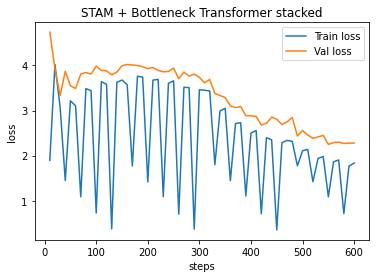

In [14]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({'steps': steps,
                   'Train loss': train_loss,
                   'Val loss': val_loss,
                   #'Train gaze loss': train_gaze_loss,
                   #'Val gaze loss': val_gaze_loss
                   })

df = df.melt('steps', var_name='',  value_name='loss')
g = sns.lineplot(x="steps", y="loss", hue='', data=df).set_title('STAM + Bottleneck Transformer stacked')